**Required libraries.**

In [ ]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

!pip install -q imageio

import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


**Dataset.**

In [ ]:
img_path = '/content/drive/MyDrive/Dataset-20230712T085451Z-001/Dataset/'

**Loading Image and Preprocessing.**

In [ ]:
from PIL import Image

dataset = []
data_size = 43
amplification = 5
for i in range(1, data_size+1):
  for j in range(amplification):
    image = Image.open(img_path + '{}.jpg'.format(i))
    img = image.resize((512,512))                      # Reshaping the images to 512,512 size
    dataset.append((np.asarray(img)-127.5)/127.5)      # Conversion of image to numpy array and Normalizing

In [ ]:
BATCH_SIZE = 4
BUFFER_SIZE = 60000
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**Generator Model.**

In [ ]:
# Generator

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32 * 32 * 1024, use_bias=False, input_shape=(100,)))  # Fix the input shape here
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 1024)))
    assert model.output_shape == (None, 32, 32, 1024)

    model.add(layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 256, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 512, 512, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 512, 512, 3)

    return model

gen = make_generator_model()


**Discriminator Model**

In [ ]:
# Discriminator

def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3,3), strides = (2,2), padding='same', input_shape = [512,512,3]))

  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (3,3), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(256, (3,3), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(512, (3,3), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(64))
  model.add(layers.Dense(1))

  return model

dcrm = make_discriminator_model()


**Loss functions and Optimizers.**

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/Dataset-20230712T085451Z-001'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, discriminator_optimizer = discriminator_optimizer, generator = gen, discriminator = dcrm)

**Training.**

In [ ]:
# Training

EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 10

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = gen(noise, training = True)
    real_output = dcrm(images, training = True)
    fake_output = dcrm(generated_images, training =True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, dcrm.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dcrm.trainable_variables))


In [ ]:
def generate_and_save_img(model, epoch, test_input):
  predictions = model(test_input, training = False)

  fig = plt.figure(figsize = (10,10))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4, i+1)
    plt.imshow(np.array((predictions[i, :, :, :]*127.5 + 127.5), np.int32))
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_img(gen, epoch+1, seed)

    if(epoch+1)%5==0:
      gen.save(checkpoint_dir)

    print('Time for epoch {} is {} secs'.format(epoch+1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_img(gen, epochs, seed)

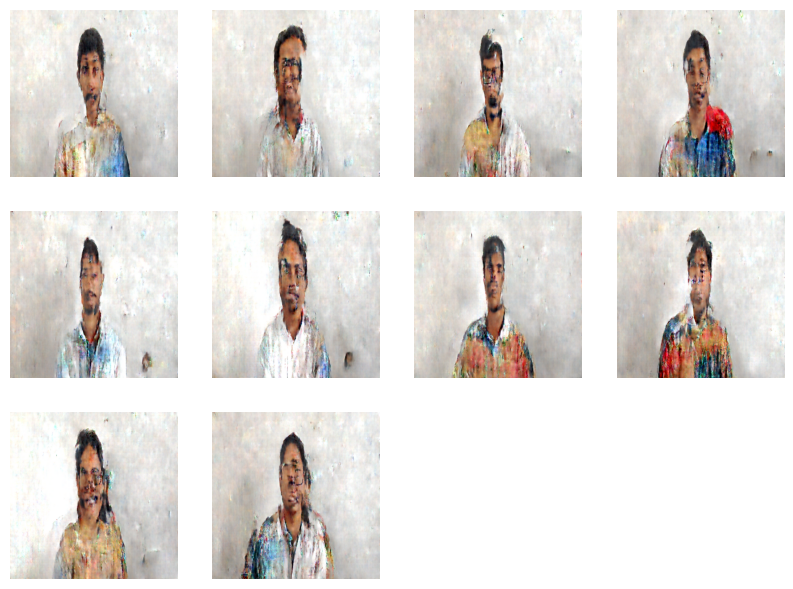

Time for epoch 475 is 45.80842924118042 secs


In [ ]:
train(train_dataset, EPOCHS)